In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.engine.topology import Layer
#from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import losses
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy.random as random
# import pandas as pd
import numpy as np
from numpy import r_
#from keras.utils.training_utils import multi_gpu_model
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras import layers


In [2]:
def n_mode_product(x, u, n):
    n = int(n)
    if n > 26:
        raise ValueError('n is too large.')
    ind = ''.join(chr(ord('a') + i) for i in range(n))

    return tf.einsum(f'L{ind}K...,JK->L{ind}J...', x, u)

t_dct = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, -1, -1, -1, -1],
                  [1, 1, -1, -1, -1, -1, 1, 1],
                  [1, -1, -1, -1, 1, 1, 1, -1],
                  [1, -1, -1, 1, 1, -1, -1, 1],
                  [1, -1, 1, 1, -1, -1, 1, -1],
                  [1, -1, 1, -1, -1, 1, -1, 1],
                  [1, -1, 1, -1, 1, -1, 1, -1]],  dtype = 'float')
print('t_dct', t_dct, t_dct.shape)
s_dct = np.diag([1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8), 1/np.sqrt(8)])
print('s_dct', s_dct, s_dct.shape)

c_dct = np.matmul(s_dct, t_dct)
if (np.matmul(np.transpose(c_dct), c_dct)==np.identity(8)).any():
    c_dct_inv = np.matmul(np.transpose(t_dct), s_dct)
else:
    c_dct_inv = np.matmul(np.linalg.inv(t_dct), np.linalg.inv(s_dct))

print('c_dct', c_dct, c_dct.shape)
print('c_dct_inv',c_dct_inv, c_dct_inv.shape)

def cal_tensor_dct_coeff(inp):
    bs, w, h, c = inp.shape
    
    dct_coeff = K.ones_like(K.variable(np.random.random((bs, w, h, c))))
    dct_coeff = tf.Variable(dct_coeff)
    block_size = 8
    #for b in range(bs):
    for i in r_[:w:block_size]:
        for j in r_[:h:block_size]:
            for k in r_[:c:block_size]:
                coe = Lambda(lambda x: n_mode_product(n_mode_product(n_mode_product(n_mode_product(n_mode_product(n_mode_product(x[0], x[1], 0), x[1], 1), x[1], 2), x[2], 0), x[2], 1), x[2], 2))([inp[:, i:(i+block_size), j:(j+block_size), k:(k+block_size)], t_dct, s_dct])
                dct_coeff[:, i:(i+block_size), j:(j+block_size), k:(k+block_size)].assign(coe)
    dct_coeff = tf.convert_to_tensor(dct_coeff)
    return dct_coeff

    
def cal_thresholded_coeff(dct_coeff, energy_retained):
    bs, w, h, c = dct_coeff.shape
    
    dct_coeff_thresh_selected = K.zeros_like(K.variable(np.random.random((bs, w, h, c))))
    dct_coeff_thresh_selected = tf.Variable(dct_coeff_thresh_selected)
    percent_energy_thresholded = K.zeros_like(K.variable(np.random.random((bs))))
    percent_energy_thresholded = tf.Variable(percent_energy_thresholded)
    
    thresh_range = [0.8, 0.6, 0.4, 0.2, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
    
    for b in range(bs):
        for th in range(len(thresh_range)):
            thresh = thresh_range[th]
            coeff_thresh = tf.math.multiply(dct_coeff[b], (tf.cast(tf.math.abs(dct_coeff[b]) > tf.math.multiply(thresh, tf.math.reduce_max(dct_coeff[b], axis = [1, 2], keepdims = True)), tf.float32)))
            percent_energy = (tf.reduce_sum(tf.math.square(coeff_thresh))/ tf.reduce_sum(tf.math.square(dct_coeff[b])))*100
            percent_energy_thresholded[b].assign(percent_energy)
            if percent_energy_thresholded[b] >= energy_retained:
                dct_coeff_thresh_selected[b].assign(coeff_thresh)
                break
    dct_coeff_thresh_selected = tf.convert_to_tensor(dct_coeff_thresh_selected)
    percent_energy_thresholded = tf.convert_to_tensor(percent_energy_thresholded)
    #return dct_coeff_thresh_selected, percent_energy_thresholded
    return dct_coeff_thresh_selected
        
def cal_reconstructed_feat(dct_coeff_thresh_selected):
    bs, w, h, c = dct_coeff_thresh_selected.shape    
    recon_feat_vis_threshold = K.zeros_like(K.variable(np.random.random((bs, w, h, c))))
    recon_feat_vis_threshold = tf.Variable(recon_feat_vis_threshold)
    block_size = 8
    #for b in range(bs):
    for i in r_[:w:block_size]:
        for j in r_[:h:block_size]:
            for k in r_[:c:block_size]:
                recon = Lambda(lambda x: n_mode_product(n_mode_product(n_mode_product(x[0], x[1], 0), x[1], 1), x[1], 2))([dct_coeff_thresh_selected[:, i:(i+block_size), j:(j+block_size), k:(k+block_size)], c_dct_inv])
                recon_feat_vis_threshold[:, i:(i+block_size), j:(j+block_size), k:(k+block_size)].assign(recon)
    recon_feat_vis_threshold = tf.convert_to_tensor(recon_feat_vis_threshold)
    return recon_feat_vis_threshold 

def tensor_dct(inp, thresh):
    dct_coeff = cal_tensor_dct_coeff(inp)
    dct_coeff_thresh_selected = cal_thresholded_coeff(dct_coeff, thresh)
    recon_feat_vis_threshold = cal_reconstructed_feat(dct_coeff_thresh_selected)
    return recon_feat_vis_threshold
    
def att_dct(inp, thresh):
    recon_feat_vis_threshold = tensor_dct(inp, thresh)
    error_score = Lambda(lambda x: 1 - K.softmax(tf.subtract(x[0], x[1])))([inp, recon_feat_vis_threshold])
    att_output = Lambda(lambda x: tf.math.multiply(x[0], tf.math.multiply(x[0], x[1])))([inp, error_score])
    return att_output


t_dct [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1. -1.  1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.]] (8, 8)
s_dct [[0.35355339 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.35355339 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.35355339 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.35355339 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.35355339 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.35355339
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.35355339 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.35355339]] (8, 8)
c_dc

In [3]:
width, height, num_ch = 128, 128, 3
num_classes = 418

def branch_model(batch_size, width, height, num_ch, num_classes, learning_rate, d, thresh):
    imgv = Input(batch_shape=(batch_size, width, height, num_ch))
    imgn = Input(batch_shape=(batch_size, width, height, num_ch))

    ## Block 1
    conv1_1v = Conv2D(16, (3, 3), activation="relu", padding = 'same')(imgv)
    conv1_2v = Conv2D(16, (3, 3), activation="relu", padding = 'same')(conv1_1v) 

    pool1v = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2v)# 48, 48, 16

    conv1_1n = Conv2D(16, (3, 3), activation="relu", padding = 'same')(imgn)
    conv1_2n = Conv2D(16, (3, 3), activation="relu", padding = 'same')(conv1_1n) 

    pool1n = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2n)# 48, 48, 16
    
    ## Block 2
    conv2_1v = Conv2D(32, (3, 3), activation="relu", padding = 'same')(pool1v)
    conv2_2v = Conv2D(32, (3, 3), activation="relu", padding = 'same')(conv2_1v)
    
    pool2v = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2v)# 24, 24, 32
    #attended_pool2v = att_dct(pool2v, thresh)
    #att_out_pool2v = BatchNormalization()(attended_pool2v)
    
    conv2_1n = Conv2D(32, (3, 3), activation="relu", padding = 'same')(pool1n)
    conv2_2n = Conv2D(32, (3, 3), activation="relu", padding = 'same')(conv2_1n)
    
    pool2n = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2n)# 24, 24, 32
    #attended_pool2n = att_dct(pool2n, thresh)
    #att_out_pool2n = BatchNormalization()(attended_pool2n)
    
    ## Block 3
    conv3_1v = Conv2D(64, (3, 3), activation="relu", padding = 'same')(pool2v)
    conv3_2v = Conv2D(64, (3, 3), activation="relu", padding = 'same')(conv3_1v)

    pool3v = MaxPooling2D((2, 2), strides=(2, 2))(conv3_2v)# 12, 12, 64
    attended_pool3v = att_dct(pool3v, thresh)
    att_out_pool3v = BatchNormalization()(attended_pool3v)
    
    conv3_1n = Conv2D(64, (3, 3), activation="relu", padding = 'same')(pool2n)
    conv3_2n = Conv2D(64, (3, 3), activation="relu", padding = 'same')(conv3_1n)

    pool3n = MaxPooling2D((2, 2), strides=(2, 2))(conv3_2n)# 12, 12, 64
    attended_pool3n = att_dct(pool3n, thresh)
    att_out_pool3n = BatchNormalization()(attended_pool3n)
    
    ## Block 4
    conv4_1v = Conv2D(128, (3, 3), activation="relu", padding = 'same')(att_out_pool3v)
    conv4_2v = Conv2D(128, (3, 3), activation="relu", padding = 'same')(conv4_1v)

    pool4v = MaxPooling2D((2, 2), strides=(2, 2))(conv4_2v)# 6, 6, 128
    attended_pool4v = att_dct(pool4v, thresh)
    att_out_pool4v = BatchNormalization()(attended_pool4v)
    
    conv4_1n = Conv2D(128, (3, 3), activation="relu", padding = 'same')(att_out_pool3n)
    conv4_2n = Conv2D(128, (3, 3), activation="relu", padding = 'same')(conv4_1n)

    pool4n = MaxPooling2D((2, 2), strides=(2, 2))(conv4_2n)# 6, 6, 128
    attended_pool4n = att_dct(pool4n, thresh)
    att_out_pool4n = BatchNormalization()(attended_pool4n)
    
    flatten_features_5v = Flatten()(att_out_pool4v)
    drop1_features_5v = Dropout(d)(flatten_features_5v)
    dense1_features_5v = Dense(512, activation='relu')(drop1_features_5v)
    drop2_features_5v = Dropout(d)(dense1_features_5v)
    dense2_features_5v = Dense(512, activation='relu')(drop2_features_5v)

    flatten_features_5n = Flatten()(att_out_pool4n)
    drop1_features_5n = Dropout(d)(flatten_features_5n)
    dense1_features_5n= Dense(512, activation='relu')(drop1_features_5n)
    drop2_features_5n = Dropout(d)(dense1_features_5n)
    dense2_features_5n = Dense(512, activation='relu')(drop2_features_5n)
    
    L2_layer = Lambda(lambda tensors: K.square(tensors[0] - tensors[1]))
    distance = L2_layer([dense2_features_5v, dense2_features_5n])
    prediction = Dense(2, activation='softmax')(distance)

    siamese_net = Model(inputs=[imgv, imgn], outputs=prediction)
    #sgd = SGD(lr=learning_rate, decay=1e-5, momentum=0.9, nesterov=True)
    #siamese_net.compile(loss="categorical_crossentropy", metrics = ['accuracy'], optimizer = sgd)
    siamese_net.compile(loss="categorical_crossentropy", metrics = ['accuracy'], optimizer=Adam(learning_rate = 0.0001))
    siamese_net.summary()
    
    return siamese_net

batch_size = 32
learning_rate = 0.0001
dropout = 0.2
energy_retained = 99.0
siamese_net = branch_model(batch_size, width, height, num_ch, num_classes, learning_rate, dropout, energy_retained)
print(len(siamese_net.layers))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 128, 128, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 128, 128, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (32, 128, 128, 16)   448         input_2[0][0]                    
_______________________________________________________________________________________

In [4]:
save_path = 'C:/Sushree/Tensor_DCT/Results/Identification/polyu/'
name = 'weights_siamese_net_dct_energy99.0_maxpool3and4_polyu_adam_bch32_lr10-4_drp0.2_200eph'

siamese_net.load_weights(save_path + name + ".h5")


In [5]:
def get_imlist(path, option):
    if option == 'tiff':
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.tiff')] # PolyU
    elif option == 'bmp':
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.bmp')] # Cross-eyed
    elif option == 'jpg':
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')] # IMP
    elif option == 'png':
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.png')] # Segmentation map

# The function 'create_data_label' is to create the database by stacking raw images onto one another along with corresponding labels.
def create_data_label(path, width, height, option):
    folder_list = os.listdir(path)
    num_class = len(folder_list)
    data = []
    label = []
    for i in range(len(folder_list)):
        img_list = get_imlist(os.path.join(path, folder_list[i]), option)
        for j in range(len(img_list)):
            img = image.load_img(img_list[j], target_size=(width, height))
            img = np.array(img)
            x = image.img_to_array(img)
            data.append(x)
            label.append(i)
    data = np.array(data, dtype=np.float32)
    return data, label

def get_index(n_classes, n_images):
    num_genuines =  (n_images**2) * n_classes # 10000
    total_num_imposters = (n_images**2) * n_classes * (n_classes - 1) # 990000

    genuine_index_pair = np.zeros((num_genuines, 2))
    imposter_index_pair = np.zeros((total_num_imposters, 2))
    genuine_folder_pair = np.zeros((num_genuines, 2))
    imposter_folder_pair = np.zeros((total_num_imposters, 2))
    genuine_count = 0
    imposter_count = 0
    for i_1 in range (n_classes): # 100 (0 to 99 )
        for i_2 in range(n_classes): # 100
            if i_1 == i_2:
                index_1 = list(range((i_1*n_images), ((i_1+1)*n_images) ))
                index_2 = list(range((i_2*n_images), ((i_2+1)*n_images) ))
                for j_1 in range(len(index_1)): # 0 to 9
                    for j_2 in range(len(index_2)): # 0 to 9
                        index_pair = np.transpose([index_1[j_1], index_2[j_2]])
                        folder_pair = np.transpose([i_1, i_2])
                        genuine_index_pair[genuine_count] = index_pair
                        genuine_folder_pair[genuine_count] = folder_pair
                        genuine_count = genuine_count + 1
            else:
                index_1 = list(range((i_1*n_images), ((i_1+1)*n_images) ))
                index_2 = list(range((i_2*n_images), ((i_2+1)*n_images) ))
                for j_1 in range(len(index_1)): # 0 to 9
                    for j_2 in range(len(index_2)): # 0 to 9
                        index_pair = np.transpose([index_1[j_1], index_2[j_2]])
                        folder_pair = np.transpose([i_1, i_2])
                        imposter_index_pair[imposter_count] = index_pair
                        imposter_folder_pair[imposter_count] = folder_pair
                        imposter_count = imposter_count + 1
    return genuine_index_pair, genuine_folder_pair, genuine_count, imposter_index_pair, imposter_folder_pair, imposter_count


In [ ]:

#Create Training Data
train_vis_path = 'C:/Sushree/Datasets/PolyU/Train/VIS'
train_vis_data, train_vis_label = create_data_label(train_vis_path, width, height, 'tiff')
print(train_vis_data.shape)
print('length of train_vis_label', len(train_vis_label))

train_nir_path = 'C:/Sushree/Datasets/PolyU/Train/NIR'
train_nir_data, train_nir_label = create_data_label(train_nir_path, width, height, 'tiff')
print(train_nir_data.shape)
print('length of train_nir_label', len(train_nir_label))


In [ ]:

num_training_images_per_class = 9
num_training_images = num_classes* num_training_images_per_class

genuine_index_pair, genuine_folder_pair, genuine_count, imposter_index_pair, imposter_folder_pair, imposter_count = get_index(num_classes, num_training_images_per_class)

n_genuine = list(range(0, genuine_count))
n_imposter = list(range(0, imposter_count))

train_genuine_index_pair, val_genuine_index_pair, train_n_genuine, val_n_genuine = train_test_split(genuine_index_pair, n_genuine, test_size=0.33, random_state=42)
train_imposter_index_pair, val_imposter_index_pair, train_n_imposter, val_n_imposter = train_test_split(imposter_index_pair, n_imposter, test_size=0.33, random_state=42)

train_genuine_count = len(train_n_genuine)
train_imposter_count = len(train_n_imposter)
true_train_imposter_count = train_genuine_count
val_genuine_count = len(val_n_genuine)
val_imposter_count = len(val_n_imposter)
true_val_imposter_count = val_genuine_count

print(train_genuine_count)
print(train_imposter_count)
print(true_train_imposter_count)
print(val_genuine_count )
print(val_imposter_count)
print(true_val_imposter_count)

print('batch_size',batch_size)
def my_data_generator_train(batch_size, width, height, num_ch, train_vis_data, train_nir_data, genuine_index_pair, genuine_count, imposter_index_pair, imposter_count, true_imposter_count):
    c = 0
    true_imposter_index = random.randint(imposter_count, size = true_imposter_count)
    total_count = genuine_count + true_imposter_count
    n_total = list(range(0, total_count))
    
    true_imposter_index_pair = np.zeros((true_imposter_count, 2))
    for i in range(true_imposter_count):
        true_imposter_index_pair[i] = imposter_index_pair[true_imposter_index[i]]
        
    total_index_pair = np.concatenate((genuine_index_pair, true_imposter_index_pair), axis = 0)
    total_targets = np.concatenate((np.ones((genuine_count, )),  np.zeros((true_imposter_count, ))), axis = 0) 
    total_targets = to_categorical(total_targets, 2)
    random.shuffle(n_total) 
    while(True):
        img_vis = np.zeros((batch_size, width, height, num_ch))
        img_nir = np.zeros((batch_size, width, height, num_ch))
        targets = np.zeros((batch_size, 2))
        if (c+batch_size < total_count):
            for i in range(c,c+batch_size):     
                img_vis[i-c]=train_vis_data[int(total_index_pair[n_total[i]][0])].reshape(width, height, num_ch)

                img_nir[i-c]=train_nir_data[int(total_index_pair[n_total[i]][1])].reshape(width, height, num_ch)

                targets[i-c] = total_targets[n_total[i]]
            input_pairs = [img_vis, img_nir]
            c+=batch_size
        if (c+batch_size >= total_count):
            c = 0
        yield input_pairs, targets

train_gen = my_data_generator_train(batch_size, width, height, num_ch, train_vis_data, train_nir_data, train_genuine_index_pair, train_genuine_count, train_imposter_index_pair, train_imposter_count, true_train_imposter_count)
val_gen = my_data_generator_train(batch_size, width, height, num_ch, train_vis_data, train_nir_data, val_genuine_index_pair, val_genuine_count, val_imposter_index_pair, val_imposter_count, true_val_imposter_count)



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# TRAINING and VALIDATION
save_path = 'C:/Sushree/Tensor_DCT/Results/'
name = 'siamese_net_dct_energy99.99_maxpool3and4_polyu_adam_bch32_lr10-4_drp0.2_200eph'

def get_callbacks(patience_lr):
            #mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_accuracy', mode='max')
            reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
            return [reduce_lr_loss]
        
#name_weights = save_path + "best_weights_" + name + ".h5"

callbacks = get_callbacks(patience_lr=10)

history = siamese_net.fit(train_gen, steps_per_epoch = int(2*train_genuine_count/batch_size), epochs = 200, verbose = 1, validation_data = val_gen, validation_steps = int(2*val_genuine_count/batch_size), callbacks = callbacks)
#history = siamese_net.fit(train_gen, steps_per_epoch = int(2*train_genuine_count/batch_size), epochs = 200, verbose = 1, callbacks = callbacks)

siamese_net.save_weights(save_path + "weights_" + name + ".h5")


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(save_path + 'acc_' + name + '.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(save_path + 'loss_' + name + '.png')


In [6]:
#TESTING
test_vis_path = 'C:/Sushree/Datasets/PolyU/Test/VIS' 
test_vis_data, test_vis_label = create_data_label(test_vis_path, width, height, 'tiff')

test_nir_path = 'C:/Sushree/Datasets/PolyU/Test/NIR'
test_nir_data, test_nir_label = create_data_label(test_nir_path, width, height, 'tiff')

num_testing_images_per_class = 6
num_testing_images = num_classes* num_testing_images_per_class

test_genuine_index_pair, test_genuine_folder_pair, test_genuine_count, test_imposter_index_pair, test_imposter_folder_pair, test_imposter_count = get_index(num_classes, num_testing_images_per_class)
print(test_genuine_count)
print(test_imposter_count)

def my_data_generator_test(batch_size, width, height, num_ch, train_vis_data, train_nir_data, genuine_index_pair, genuine_count, imposter_index_pair, imposter_count, option):
    c = 0
    total_count = genuine_count + imposter_count
    n_total = list(range(0, total_count))
    total_index_pair = np.concatenate((genuine_index_pair, imposter_index_pair), axis = 0)
    total_targets = np.concatenate((np.ones((genuine_count, )),  np.zeros((imposter_count, ))), axis = 0)
    total_targets = to_categorical(total_targets, 2)

    while(True):
        img_vis = np.zeros((batch_size, width, height, num_ch))
        img_nir = np.zeros((batch_size, width, height, num_ch))
        targets = np.zeros((batch_size, 2))
        if (c+batch_size < total_count):
            for i in range(c,c+batch_size):     
                img_vis[i-c]=train_vis_data[int(total_index_pair[n_total[i]][0])].reshape(width, height, num_ch)

                img_nir[i-c]=train_nir_data[int(total_index_pair[n_total[i]][1])].reshape(width, height, num_ch)

                targets[i-c] = total_targets[n_total[i]]
            input_pairs = [img_vis, img_nir]
            c+=batch_size
        if (c+batch_size >= total_count):
            c = 0
        if option == 'evaluate':    
            yield input_pairs, targets
        elif option == 'predict':
            yield input_pairs
              
test_gen_evaluate = my_data_generator_test(batch_size, width, height, num_ch, test_vis_data, test_nir_data, test_genuine_index_pair, test_genuine_count, test_imposter_index_pair, test_imposter_count, 'evaluate')

test_gen_predict = my_data_generator_test(batch_size, width, height, num_ch, test_vis_data, test_nir_data, test_genuine_index_pair, test_genuine_count, test_imposter_index_pair, test_imposter_count, 'predict')


15048
6275016


In [ ]:
siamese_net.evaluate(test_gen_evaluate,steps = int((test_genuine_count+ 15032)/batch_size),verbose=1)

predictions_test=siamese_net.predict(test_gen_predict, steps=int((test_genuine_count + 15032)/batch_size),verbose=1)

predictions_test_max=np.argmax(predictions_test,axis=1)
np.shape(predictions_test_max)

test_input_targets = np.concatenate((np.ones((test_genuine_count, )),  np.zeros((15032, ))), axis = 0)
test_input_targets_categorical = to_categorical(test_input_targets, 2)
print(test_input_targets.shape)
print(test_input_targets_categorical.shape)

from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score
p= precision_score(test_input_targets, predictions_test_max)
r= recall_score(test_input_targets, predictions_test_max)
print("P=", p)
print("R=", r)
p= precision_score(test_input_targets, predictions_test_max, average='macro')
r= recall_score(test_input_targets, predictions_test_max, average='macro')
print("P_macro=", p)
print("R_macro=", r)

f1= f1_score(test_input_targets, predictions_test_max)
print("f1=", f1)

f1= f1_score(test_input_targets, predictions_test_max, average='macro')
print("f1_macro=", f1)

cc= confusion_matrix(test_input_targets, predictions_test_max)
print(cc)

from sklearn.metrics import roc_curve, auc, log_loss
from numpy import *
lw=2
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_input_targets_categorical[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr 
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["macro"], tpr["macro"],label='ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),color='r', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right"),
plt.show()

name_test = 'wt_'+ name
np.save (save_path +'pred_'+name_test+'.npy',predictions_test)
np.save(save_path +'fpr_'+name_test+'.npy',all_fpr)
np.save(save_path +'tpr_'+ name_test+'.npy',mean_tpr)
plt.savefig(save_path +'ROC_'+name_test+'.png')
print('Done')


In [7]:
siamese_net.evaluate(test_gen_evaluate,steps = int((test_genuine_count+ test_imposter_count)/batch_size),verbose=1)

predictions_test=siamese_net.predict(test_gen_predict, steps=int((test_genuine_count + test_imposter_count)/batch_size),verbose=1)

predictions_test_max=np.argmax(predictions_test,axis=1)
np.shape(predictions_test_max)

test_input_targets = np.concatenate((np.ones((test_genuine_count, )),  np.zeros((test_imposter_count, ))), axis = 0)
test_input_targets_categorical = to_categorical(test_input_targets, 2)
print(test_input_targets.shape)
print(test_input_targets_categorical.shape)

196564/196564 [==============================] - 3531s 18ms/step
(6290064,)
(6290064, 2)


In [8]:
print(predictions_test_max.shape)
print(predictions_test_max.shape[0])

(6290048,)
6290048


In [ ]:
save_path = 'C:/Sushree/Tensor_DCT/Results/'
np.save (save_path + 'test_genuine_index_pair.npy', test_genuine_index_pair)
np.save (save_path + 'test_genuine_folder_pair.npy', test_genuine_folder_pair)
np.save (save_path + 'test_imposter_index_pair.npy', test_imposter_index_pair)
np.save (save_path + 'test_imposter_folder_pair.npy', test_imposter_folder_pair)

P= 0.0659070568905868
R= 0.983652312599681
P_macro= 0.532933249683208
R_macro= 0.9751100606823107
f1= 0.12353684948484582
f1_macro= 0.5532584900633319
[[6065213  209787]
 [    246   14802]]


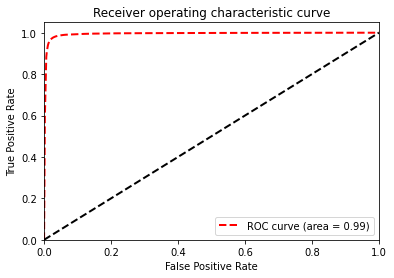

Done


<Figure size 432x288 with 0 Axes>

In [9]:

from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score
p= precision_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max)
r= recall_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max)
print("P=", p)
print("R=", r)
p= precision_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max, average='macro')
r= recall_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max, average='macro')
print("P_macro=", p)
print("R_macro=", r)

f1= f1_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max)
print("f1=", f1)

f1= f1_score(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max, average='macro')
print("f1_macro=", f1)

cc= confusion_matrix(test_input_targets[0:predictions_test_max.shape[0]], predictions_test_max)
print(cc)

from sklearn.metrics import roc_curve, auc, log_loss
from numpy import *
lw=2
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_input_targets_categorical[0:predictions_test_max.shape[0], i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr 
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["macro"], tpr["macro"],label='ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),color='r', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right"),
plt.show()

name_test = 'wt_'+ name +'_tstAll'
np.save (save_path +'pred_'+name_test+'.npy',predictions_test)
np.save(save_path +'fpr_'+name_test+'.npy',all_fpr)
np.save(save_path +'tpr_'+ name_test+'.npy',mean_tpr)
plt.savefig(save_path +'ROC_'+name_test+'.png')
print('Done')
